In [3]:
# autoimport 
%load_ext autoreload
%autoreload 2
from impute import estimate_lnorm, impute_from_sd, sample_from_lognormal, impute_from_subsistence

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [578]:
import numpy as np
import pandas as pd
import tqdm

import scipy.stats as st
from scipy.stats import norm

# hide RuntimeWarning pandas
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [124]:
import numba

# @numba.jit(nopython=True)
def gini_coefficient(array):
    # array = np.array(array)
    n = array.shape[0]
    array_sorted = np.sort(array)
    index = np.arange(1, n+1)
    weighted_sum = (array_sorted * index).sum()
    
    gini = (2 * weighted_sum) / (n * array.sum()) - (n + 1) / n
    return gini

test_array = np.array((5 * [50]) + (10 * [100]) + (5 * [300]))
gini = gini_coefficient(test_array)


## Laad data

In [5]:
## CBS summary data
cbs_sum_fp = "/Users/werk/Documents/git_hipnl/uu_link_dev/analyse_bestanden/n_pers_per_adres_en_stats_cats_2023_06_28_v2.xlsx"
cbs_sum = pd.read_excel(cbs_sum_fp)

# voeg year_mun_id toe
cbs_sum['year_mun_id'] = cbs_sum['year'].astype(str) + "_" + cbs_sum['municipality_cbs'].str.replace(" ", "_")

cbs_sum.fillna(0, inplace=True)

cbs_sum.head()

,year,cbs_year,amco,municipality_kohier,municipality_cbs,pct_records_included,n_all_records,n_records,n_adresses,n_adresses_surname,...,cat4,cat_sum,cat1_pct,cat2_pct,cat3_pct,cat4_pct,omvang_hh,hh_per_huis,inw_per_huis,year_mun_id
0,1889,1889,10327,Doesburg,Doesburg,0.976909,563,550,406,512,...,5,406,0.724,0.062,0.202,0.012,4.056147,1.222485,5.274556,1889_Doesburg
1,1879,1879,10327,Doesburg,Doesburg,0.996289,539,537,417,528,...,3,417,0.784,0.014,0.194,0.007,4.079380,1.141436,5.007735,1879_Doesburg
2,1881,1879,10909,Harlingen,Harlingen,0.972973,37,36,35,36,...,0,35,0.971,0.000,0.029,0.000,4.168417,1.223925,5.295106,1881_Harlingen
3,1889,1889,10909,Harlingen,Harlingen,0.982618,978,961,802,918,...,4,802,0.827,0.041,0.127,0.005,4.184792,0.000000,0.000000,1889_Harlingen
4,1899,1899,10007,Vaals,Vaals,0.986627,1346,1328,662,1264,...,39,662,0.601,0.030,0.310,0.059,4.192908,1.923602,8.673943,1899_Vaals


CBS DATA LARGE

In [790]:
## load cbs_sum_large, for determining refpop for municipalities without adress data
cbs_sum_large = pd.read_parquet("cbs_stats_summarized_all_municipalities_2023_07_06.parquet", engine="pyarrow")

# merge with cbs_sum
cbs_sum_large = pd.merge(cbs_sum_large, cbs_sum[['cbs_year','amco', 'cat1_pct', 'cat2_pct', 'cat3_pct', 'cat4_pct']], left_on=['amco', 'year'], right_on=['amco', 'cbs_year'], how='left')

# calculate refpop column
# berekenen proporties
cbs_sum_large['refpop'] = cbs_sum_large.cat1 * cbs_sum_large.cat1_pct + cbs_sum_large.cat2 * cbs_sum_large.cat2_pct + cbs_sum_large.cat3 * cbs_sum_large.cat3_pct
# make cbs_sum['refpop_prop'] integer
cbs_sum_large['refpop'] = cbs_sum_large['refpop'].astype(int)

cbs_sum_large.head()

,year,amco,municipality,bewoonde_huizen,bewoonde_schepen,afzonderlijk_levenden,huisgezinnen,bevolking,beroepsbevolking,bewoonde_huizen_schepen,...,verwant_huizing,cat1,cat2,cat3,cbs_year,cat1_pct,cat2_pct,cat3_pct,cat4_pct,refpop
0,1849,10534,'s-Graveland,143.0,1.0,0.0,270.0,1247.0,<NA>,144.0,...,<NA>,270.0,540.0,270.0,NaN,NaN,NaN,NaN,NaN,0
1,1849,10052,'s-Gravendeel,312.0,0.0,0.0,530.0,2368.0,<NA>,312.0,...,<NA>,530.0,1060.0,530.0,NaN,NaN,NaN,NaN,NaN,0
2,1849,11434,'s-Gravenhage,10346.0,92.0,0.0,16011.0,72225.0,<NA>,10438.0,...,<NA>,16011.0,32022.0,16011.0,NaN,NaN,NaN,NaN,NaN,0
3,1849,10469,'s-Gravenmoer,113.0,0.0,0.0,175.0,825.0,<NA>,113.0,...,<NA>,175.0,350.0,175.0,NaN,NaN,NaN,NaN,NaN,0
4,1849,11059,'s-Gravenpolder,109.0,0.0,0.0,139.0,667.0,<NA>,109.0,...,<NA>,139.0,278.0,139.0,NaN,NaN,NaN,NaN,NaN,0


TAX DATA

In [6]:
tax_records_fp = "/Users/werk/Documents/git_hipnl/data/tax_records/tax_records_latest.parquet"
tax_records = pd.read_parquet(tax_records_fp, engine='pyarrow')
tax_records.head()

,page_nr,place,volgnummer,wijk,house_nr_wijk,street,house_nr_street,title,firstnames,initials,...,moved_address,marital_status,tax_raad2,deducations,income,month,notes_cleaning,cbs_year,cbscode,year_mun_id
0,1,Eindhoven,1,<NA>,<NA>,Kerkstraat,9,Wed,<NA>,H.,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1920,GM0772,1917_Eindhoven
1,1,Eindhoven,2,<NA>,<NA>,Vrijstraat,47,<NA>,<NA>,A.,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1920,GM0772,1917_Eindhoven
2,1,Eindhoven,3,<NA>,<NA>,Vrijstraat,1,<NA>,Cath.,C.,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1920,GM0772,1917_Eindhoven
3,1,Eindhoven,4,<NA>,<NA>,Markt,14,<NA>,<NA>,H.,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1920,GM0772,1917_Eindhoven
4,1,Eindhoven,5,<NA>,<NA>,Prins Hendrikstraat,7a,<NA>,<NA>,J.,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1920,GM0772,1917_Eindhoven


In [12]:
tax_schedule_fp = "/Users/werk/Documents/git_hipnl/data/tax_records/tax_schedule_latest.parquet"
tax_schedule = pd.read_parquet(tax_schedule_fp, engine='pyarrow')
tax_schedule.head()

,class_nr,min,max,verhoudingscijfer,tax,grondslag voor berekening van de aanslag,year,file_name,place,municipality,...,has_duplicate,file_id,sheet_name,pct,pct1,tax1,pct2,tax2,income_gross,income_taxable
0,1,300,400,0.125,<NA>,50.0,1909,Uden_1909_2.2.xlsx,Uden,Uden,...,False,13021329944,tax_schedule,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,2,401,500,0.125,<NA>,62.5,1909,Uden_1909_2.2.xlsx,Uden,Uden,...,False,13021329944,tax_schedule,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,3,501,600,0.125,<NA>,75.0,1909,Uden_1909_2.2.xlsx,Uden,Uden,...,False,13021329944,tax_schedule,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,4,601,700,0.150,<NA>,105.0,1909,Uden_1909_2.2.xlsx,Uden,Uden,...,False,13021329944,tax_schedule,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,5,701,800,0.150,<NA>,120.0,1909,Uden_1909_2.2.xlsx,Uden,Uden,...,False,13021329944,tax_schedule,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [33]:
# add year_mun_id to tax_schedule
file_id_year_mun_id_mapping = tax_records[['file_id', 'year_mun_id']].drop_duplicates().set_index('file_id').to_dict()['year_mun_id']
tax_schedule['year_mun_id'] = tax_schedule.file_id.map(file_id_year_mun_id_mapping)

## Bewerk en filter data

#### Berwerk cbs

In [817]:
# refpop_cat1 = CBS_munics$huisgezinnen + CBS_munics$afzonderlijk_levenden
cbs_sum['cat1'] = cbs_sum['huisgezinnen'] + cbs_sum['afzonderlijk_levenden']

# refpop_cat2 = CBS_munics$afzonderlijk_levenden + (CBS_munics$huisgezinnen*2) + CBS_munics$overige_leden_huisgezin
cbs_sum['cat2'] = cbs_sum['afzonderlijk_levenden'] + (cbs_sum['huisgezinnen']*2) + cbs_sum['overige_leden_huisgezin']

# refpop_cat3 = CBS_munics$afzonderlijk_levenden + CBS_munics$huisgezinnen + CBS_munics$overige_leden_huisgezin
cbs_sum['cat3'] = cbs_sum['afzonderlijk_levenden'] + cbs_sum['huisgezinnen'] + cbs_sum['overige_leden_huisgezin'] + cbs_sum['niet_verwant_huizing']

# berekenen proporties
cbs_sum['refpop_prop'] = cbs_sum.cat1 * cbs_sum.cat1_pct + cbs_sum.cat2 * cbs_sum.cat2_pct + cbs_sum.cat3 * cbs_sum.cat3_pct
# make cbs_sum['refpop_prop'] integer
cbs_sum['refpop_prop'] = cbs_sum['refpop_prop'].astype(int)


# filte cbs_sum where no refpop is present
cbs_sum_ref = cbs_sum[cbs_sum.refpop_prop > 0]
cbs_sum_ref.head()

,year,cbs_year,amco,municipality_kohier,municipality_cbs,pct_records_included,n_all_records,n_records,n_adresses,n_adresses_surname,...,cat_sum,cat1_pct,cat2_pct,cat3_pct,cat4_pct,omvang_hh,hh_per_huis,inw_per_huis,year_mun_id,refpop_prop
0,1889,1889,10327,Doesburg,Doesburg,0.976909,563,550,406,512,...,406,0.724,0.062,0.202,0.012,4.056147,1.222485,5.274556,1889_Doesburg,1352
1,1879,1879,10327,Doesburg,Doesburg,0.996289,539,537,417,528,...,417,0.784,0.014,0.194,0.007,4.079380,1.141436,5.007735,1879_Doesburg,1255
2,1881,1879,10909,Harlingen,Harlingen,0.972973,37,36,35,36,...,35,0.971,0.000,0.029,0.000,4.168417,1.223925,5.295106,1881_Harlingen,2543
3,1889,1889,10909,Harlingen,Harlingen,0.982618,978,961,802,918,...,802,0.827,0.041,0.127,0.005,4.184792,0.000000,0.000000,1889_Harlingen,2817
4,1899,1899,10007,Vaals,Vaals,0.986627,1346,1328,662,1264,...,662,0.601,0.030,0.310,0.059,4.192908,1.923602,8.673943,1899_Vaals,1771


Filter cbs_sum_large -> keep year mun from tax records

In [879]:
##  filter cbs_sum_large; keep amco-year combiniations that are in tax_records
# create amco_year column
tax_records['amco_year'] = tax_records.amco.astype(str) + "_" + tax_records.cbs_year.astype(str)
cbs_sum_large['amco_year'] = cbs_sum_large.amco.astype(str) + "_" + cbs_sum_large.year.astype(str)

# Add year_mun_id to cbs_sum_large
# create mapping
acmo_year_mun_id_mapping = tax_records[['amco_year', 'year_mun_id']].drop_duplicates().set_index('amco_year').to_dict()['year_mun_id']
# map to cbs_large
cbs_sum_large['year_mun_id'] = cbs_sum_large.amco_year.map(acmo_year_mun_id_mapping)

# filter cbs_sum_large
cbs_sum_large_filt = cbs_sum_large.query("amco_year.isin(@tax_records.amco_year)").copy()

# inspect missing
missing_amco_year = [i for i in tax_records.amco_year.unique().tolist() if i not in cbs_sum_large_filt.amco_year.tolist()]
tax_records.query("amco_year.isin(@missing_amco_year)").year_mun_id.unique()

<StringArray>
['1889_Vaals', '1890_Swalmen', '1889_Schinnen', '1890_Meerlo',
 '1889_Beek_(L.)']
Length: 5, dtype: string

In [880]:
# create copy of cbs_sum_large_filt. This will be used to impute refpop for municipalities without adress data
cbs_large = cbs_sum_large_filt.copy()

# add columnn in indicating the source of the refpop value
cbs_large.loc[cbs_large.refpop > 0, 'refpop_source'] = 'cat_proportions'

# use beroepsbevolking where refpop is missing
brp_refpop_rows = cbs_large.eval("refpop.notna() & refpop_source.isna() & beroepsbevolking.notna()")
cbs_large.loc[brp_refpop_rows, "refpop"] = cbs_large.loc[brp_refpop_rows, "beroepsbevolking"]
cbs_large.loc[brp_refpop_rows, "refpop_source"] = "brp_value"

# make refpop integer
cbs_large.refpop = cbs_large.refpop.astype(int)

cbs_large.head()

,year,amco,municipality,bewoonde_huizen,bewoonde_schepen,afzonderlijk_levenden,huisgezinnen,bevolking,beroepsbevolking,bewoonde_huizen_schepen,...,cat3,cbs_year,cat1_pct,cat2_pct,cat3_pct,cat4_pct,refpop,amco_year,year_mun_id,refpop_source
16,1849,11020,Aardenburg,282.0,0.0,0.0,369.0,1628.0,<NA>,282.0,...,369.0,NaN,NaN,NaN,NaN,NaN,0,11020_1849,1849_Aardenburg,NaN
1193,1859,11020,Aardenburg,308.0,0.0,54.0,337.0,1635.0,<NA>,308.0,...,524.0,1859.0,0.917,0.019,0.064,0.000,405,11020_1859,1859_Aardenburg,cat_proportions
1265,1859,11374,Beek (L.),520.0,0.0,23.0,504.0,2572.0,<NA>,520.0,...,775.0,NaN,NaN,NaN,NaN,NaN,0,11374_1859,1860_Beek_(L.),NaN
1305,1859,11006,Bladel en Netersel,252.0,0.0,24.0,275.0,1342.0,<NA>,252.0,...,408.0,NaN,NaN,NaN,NaN,NaN,0,11006_1859,1859_Bladel_en_Netersel,NaN
1343,1859,10030,Brouwershaven,271.0,17.0,12.0,336.0,1648.0,<NA>,288.0,...,508.0,1859.0,0.698,0.000,0.287,0.016,388,10030_1859,1859_Brouwershaven,cat_proportions


In [969]:
cbs_large.year_mun_id.isna().sum()

0

In [970]:
cbs_large

,year,amco,municipality,bewoonde_huizen,bewoonde_schepen,afzonderlijk_levenden,huisgezinnen,bevolking,beroepsbevolking,bewoonde_huizen_schepen,...,cat3,cbs_year,cat1_pct,cat2_pct,cat3_pct,cat4_pct,refpop,amco_year,year_mun_id,refpop_source
16,1849,11020,Aardenburg,282.0,0.0,0.0,369.0,1628.0,<NA>,282.0,...,369.0,NaN,NaN,NaN,NaN,NaN,0,11020_1849,1849_Aardenburg,NaN
1193,1859,11020,Aardenburg,308.0,0.0,54.0,337.0,1635.0,<NA>,308.0,...,524.0,1859.0,0.917,0.019,0.064,0.000,405,11020_1859,1859_Aardenburg,cat_proportions
1265,1859,11374,Beek (L.),520.0,0.0,23.0,504.0,2572.0,<NA>,520.0,...,775.0,NaN,NaN,NaN,NaN,NaN,0,11374_1859,1860_Beek_(L.),NaN
1305,1859,11006,Bladel en Netersel,252.0,0.0,24.0,275.0,1342.0,<NA>,252.0,...,408.0,NaN,NaN,NaN,NaN,NaN,0,11006_1859,1859_Bladel_en_Netersel,NaN
1343,1859,10030,Brouwershaven,271.0,17.0,12.0,336.0,1648.0,<NA>,288.0,...,508.0,1859.0,0.698,0.000,0.287,0.016,388,10030_1859,1859_Brouwershaven,cat_proportions
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8663,1920,11141,Uden,1228.0,0.0,0.0,<NA>,6888.0,<NA>,1228.0,...,0.0,1920.0,0.897,0.035,0.060,0.008,0,11141_1920,1920_Uden,NaN
8677,1920,10007,Vaals,852.0,0.0,0.0,<NA>,7831.0,<NA>,852.0,...,0.0,1920.0,0.303,0.187,0.240,0.270,0,10007_1920,1920_Vaals,NaN
8681,1920,11064,Varik,244.0,1.0,0.0,<NA>,1071.0,<NA>,245.0,...,0.0,NaN,NaN,NaN,NaN,NaN,0,11064_1920,1920_Varik,NaN
8694,1920,11414,"Vessem, Wintelre en Knegsel",230.0,0.0,0.0,<NA>,1186.0,<NA>,230.0,...,0.0,NaN,NaN,NaN,NaN,NaN,0,11414_1920,"1920_Vessem,_Wintelre_en_Knegsel",NaN


#### Bewerk tax data

In [9]:
# income_columns = ['income_gross', 'income', 'income_unspecified', 'income_raad', 'income_taxable']
# # income_columns = ['income_taxable', 'income_gross','income_unspecified', 'tax', 'tax2', 'class_raad', 'income_raad', 'tax_raad', 'tax2_raad', 'tax_raad2', 'class']
# income_columns = ['tax', 'tax2', 'tax_raad', 'tax_raad2', 'tax2_raad']
# income_columns

['tax', 'tax2', 'tax_raad', 'tax_raad2', 'tax2_raad']

In [19]:
# income_columns = ['tax', 'tax2', 'tax_raad', 'tax_raad2', 'tax2_raad']

# # keep rows where income columns are not empty
# tax_records_inc = tax_records[tax_records[income_columns].notnull().any(axis=1)].copy()

# # add column income_impute to tax_records_inc, which consists of one of the columns from income_columns, in order of preference
# tax_records_inc[['income_impute', 'income_impute_from']] = tax_records_inc.apply(lambda row: pd.Series(get_income_value(row, income_columns)), axis=1)

# # bewaar de rijen waarvan de year_mun_id in cbs_sum_ref zit
# tax_records_inc_ref = tax_records_inc.query("year_mun_id.isin(@cbs_sum_ref.year_mun_id.unique())")
# print(len(tax_records_inc_ref))

# tax_records_inc.head()

13762


,page_nr,place,volgnummer,wijk,house_nr_wijk,street,house_nr_street,title,firstnames,initials,...,tax_raad2,deducations,income,month,notes_cleaning,cbs_year,cbscode,year_mun_id,income_impute,income_impute_from
0,1,Eindhoven,1,<NA>,<NA>,Kerkstraat,9,Wed,<NA>,H.,...,<NA>,<NA>,<NA>,<NA>,<NA>,1920,GM0772,1917_Eindhoven,9.6,tax
1,1,Eindhoven,2,<NA>,<NA>,Vrijstraat,47,<NA>,<NA>,A.,...,<NA>,<NA>,<NA>,<NA>,<NA>,1920,GM0772,1917_Eindhoven,14.4,tax
2,1,Eindhoven,3,<NA>,<NA>,Vrijstraat,1,<NA>,Cath.,C.,...,<NA>,<NA>,<NA>,<NA>,<NA>,1920,GM0772,1917_Eindhoven,19.2,tax
3,1,Eindhoven,4,<NA>,<NA>,Markt,14,<NA>,<NA>,H.,...,<NA>,<NA>,<NA>,<NA>,<NA>,1920,GM0772,1917_Eindhoven,35.2,tax
4,1,Eindhoven,5,<NA>,<NA>,Prins Hendrikstraat,7a,<NA>,<NA>,J.,...,<NA>,<NA>,<NA>,<NA>,<NA>,1920,GM0772,1917_Eindhoven,16.0,tax


In [796]:
# # bewaar de rijen waarvan de year_mun_id in cbs_sum_ref zit
# tax_records_inc_ref = tax_records_inc.query("year_mun_id.isin(@cbs_sum_ref.year_mun_id.unique())")

# tax_records_inc_ref.year_mun_id.unique()

In [955]:
tax_records.query("year_mun_id == '1909_Utrecht'").has_duplicates

AttributeError: 'DataFrame' object has no attribute 'has_duplicates'

In [957]:
tax_records.query("year_mun_id == '1909_Utrecht'").has_duplicate

10521    False
10522    False
10523    False
10524    False
10525    False
         ...  
11816    False
11817    False
11818    False
11819    False
11820    False
Name: has_duplicate, Length: 1300, dtype: bool[pyarrow]

In [949]:
tax_records.should_look.notna().sum()

70417

In [952]:
tax_records.should_look.sum()

299

## Imputaties

In [343]:
# tax_records_inc_ref_grp = tax_records_inc_ref.groupby("year_mun_id")

# grp_key = list(tax_records_inc_ref_grp.groups.keys())[0]

# grp_key = "1889_Harlingen"
# grp = tax_records_inc_ref_grp.get_group(grp_key)

# len(tax_records_inc_ref_grp)

#### Imputatie functie

In [10]:
def get_income_value(row, income_columns):
    """Get income value from row"""
    for col in income_columns:
        if pd.notnull(row[col]):
            if row[col] >= 0:
                return (row[col], col)
    return (None, None)

In [835]:
# tax_records_inc_ref_grp = tax_records_inc_ref.groupby("year_mun_id")
# print(f"{len(tax_records_inc_ref_grp)} municipalities with refpop\n")

def impute_income_values_df(tax_records_inc_ref, income_column="income_impute", refpop_column="refpop_prop", cbs_data=cbs_sum_ref, print_info=True):


    tax_records_inc_ref_grp = tax_records_inc_ref.groupby("year_mun_id")
    if print_info:
        print(f"{len(tax_records_inc_ref_grp)} municipalities with refpop\n")

    imputed_results = []

    for grp_key, grp in tax_records_inc_ref_grp:

        # get stats for this municipality
        stats_muni = cbs_data.query("year_mun_id == @grp_key")
        # get number of refpop
        n_refpop = stats_muni[refpop_column].values[0]
        # get number of missing
        n_missing = n_refpop - len(grp)

        # get values to impute
        y_to_impute = grp.query(f"{income_column} > 0")[income_column]
        # get minimum income
        min_inc = y_to_impute.min()

        if print_info:
            print(f"{grp_key}\n{min_inc = }, {n_refpop = }, {n_missing = }, n_belast = {len(grp)}, huishoudens: {stats_muni.huishoudens.values[0]}\n")

        # impute values. returns a numpy array with original values and imputed values

        imputed = sample_from_lognormal(y_to_impute, n_missing)

        # only missing values
        missing_imputed = imputed[n_missing:]
        missing_df = pd.Series(missing_imputed).to_frame().rename(columns={0: income_column})
        # add year_mun_id
        missing_df['year_mun_id'] = grp_key
        # add surname column, to be able to identify imputed values
        missing_df['surname'] = "IMPUTED"
        # add column indicating from which column the imputation was done
        impute_from = grp.income_impute_from.unique()[0]
        missing_df['income_impute_from'] = f"{impute_from}_imputed"

        imputed_results.append(missing_df)

    # merge
    imputed_df = pd.concat(imputed_results)


    # merge with tax_records_inc_ref
    imputed_df_tax_records = pd.concat([tax_records_inc_ref, imputed_df], ignore_index=True)

    # sort, so that all year_mun_id are together
    imputed_df_tax_records.sort_values(by=['year_mun_id', income_column], ascending=False, inplace=True)

    return imputed_df_tax_records


# imputed_df = impute_income_values_df(tax_records_inc_ref)

In [836]:
def quick_gini_simulation(tax_records_inc_ref, year_mun_id=None, income_column="income_impute", refpop_column="refpop_prop", cbs_data=cbs_sum_ref, rounds=100):

    if year_mun_id is None:
        year_mun_id = tax_records_inc_ref.year_mun_id.unique()[0]

    grp = tax_records_inc_ref.query(f"year_mun_id == '{year_mun_id}'")
    # get stats for this municipality
    stats_muni = cbs_data.query("year_mun_id == @year_mun_id")
    # get number of refpop
    n_refpop = stats_muni[refpop_column].values[0]
    # get number of missing
    n_missing = n_refpop - len(grp)

    # get values to impute
    y_to_impute = grp.query(f"{income_column} > 0")[income_column]
    # get minimum income
    min_inc = y_to_impute.min()

    ginis = []
    for i in tqdm.tqdm(range(rounds)):
        imputed = sample_from_lognormal(y_to_impute, n_missing)
        gini = gini_coefficient(imputed)
        ginis.append(gini)

    ginis = pd.Series(ginis)
    return ginis

In [888]:
def impute_income_values_year_mun(df, income_column="income_impute", refpop_column="refpop_prop", cbs_data=cbs_sum_ref):
    """Impute income values for a single column for a single year_mun_id"""

    year_mun_id = df.year_mun_id.unique()[0]
    # get stats for this municipality
    stats_muni = cbs_data.query("year_mun_id == @year_mun_id")
    try:
        # get number of refpop
        n_refpop = stats_muni[refpop_column].values[0]
    except:
        print(f"no refpop for {year_mun_id}. {stats_muni.shape[0]} rows in cbs_data filter. Refpop value: {stats_muni[refpop_column].values}. {refpop_column = }")
        raise ValueError
        
    # get number of missing
    n_missing = n_refpop - df.shape[0]
    print(f"{n_missing = }, {n_refpop = }, n_belast = {df.shape[0]}, huishoudens: {stats_muni.huishoudens.values[0]}\n")
    
    # get values to impute
    y_to_impute = df.query(f"{income_column} > 0")[income_column]

    # check if there are multiple distinct values in y_to_impute (otherwise there is no distribution)
    if len(y_to_impute.unique()) == 1:
        print(f"Only one distinct value in {income_column} for {year_mun_id}. Skipping imputation.")
        return pd.DataFrame()

    # impute values. returns a numpy array with original values and imputed values
    imputed = sample_from_lognormal(y_to_impute, n_missing)

    # only missing values
    imputed_df = pd.Series(imputed).to_frame().rename(columns={0: f"{income_column}_imputed"})
    # add year_mun_id
    imputed_df['year_mun_id'] = year_mun_id

    # Add column indicating from which column the imputation was done
    imputed_df[f"is_{income_column}_imputed"] = False
    imputed_df.loc[len(y_to_impute) :, f"is_{income_column}_imputed"] = True

    # add original index
    imputed_df['original_index'] = np.nan
    imputed_df.loc[: df.shape[0]-1, 'original_index'] = df.index.tolist()
    
    return imputed_df



def impute_all_income_columns(df, columns_to_impute, refpop_column="refpop_prop", cbs_data=cbs_sum_ref):
    """
    Impute all columns in columns_to_impute for a given year_mun_id (df)
    """

    missing_dfs = []
    # impute all columns that are more than 50% filled
    for col in columns_to_impute:
        print(col)
        missing_df = impute_income_values_year_mun(df, income_column=col, refpop_column=refpop_column, cbs_data=cbs_data)
        if missing_df.shape[0] > 0:
            missing_dfs.append(missing_df)

    if len(missing_dfs) == 0:
        return pd.DataFrame()
        
    # join all missing_dfs on year_mun_id and surname
    missing_df = pd.concat(missing_dfs, ignore_index=False, axis=1, join="inner")

    # drop year_mun_id columns (because they are all the same)
    missing_df.drop(columns="year_mun_id", inplace=True)

    # add new year_mun_id column, for joining with tax_records_inc_ref
    missing_df['year_mun_id'] = df.year_mun_id.unique()[0]
    
    # column that indicates the original index value
    if len(columns_to_impute) > 1:
        missing_df['original_index_value'] = missing_df['original_index'].apply(lambda x : list(set(x))[0], axis=1)
    else:
        missing_df['original_index_value'] = missing_df['original_index']
    # add column indicating this row is an complete imputation
    missing_df['imputed_record'] = missing_df['original_index_value'].isna()

    # drop original_index
    missing_df.drop(columns='original_index', inplace=True)

    return missing_df

### Experimenten

#### impute income

In [973]:
income_columns = ['income_gross', 'income', 'income_unspecified', 'income_raad', 'income_taxable']

# keep rows where income columns are not empty
tax_records_inc = tax_records[tax_records[income_columns].notnull().any(axis=1)].copy()

# add column income_impute to tax_records_inc, which consists of one of the columns from income_columns, in order of preference
tax_records_inc[['income_impute', 'income_impute_from']] = tax_records_inc.apply(lambda row: pd.Series(get_income_value(row, income_columns)), axis=1)

# bewaar de rijen waarvan de year_mun_id in cbs_sum_ref zit
# tax_records_inc_ref = tax_records_inc.query("year_mun_id.isin(@cbs_sum_ref.year_mun_id.unique())").copy()
cbs_large_refpop = cbs_large.query("refpop > 0").copy()
# tax_records_inc_ref = tax_records_inc.query("year_mun_id.isin(@cbs_large_refpop.year_mun_id.unique())").copy()

tax_records_inc_ref = tax_records_inc.query("year_mun_id.isin(@cbs_large.year_mun_id.unique())").copy()

print(len(tax_records_inc_ref))

tax_records_inc.head()

29240


,page_nr,place,volgnummer,wijk,house_nr_wijk,street,house_nr_street,title,firstnames,initials,...,deducations,income,month,notes_cleaning,cbs_year,cbscode,year_mun_id,amco_year,income_impute,income_impute_from
0,1,Eindhoven,1,<NA>,<NA>,Kerkstraat,9,Wed,<NA>,H.,...,<NA>,<NA>,<NA>,<NA>,1920,GM0772,1917_Eindhoven,11298_1920,1000.0,income_gross
1,1,Eindhoven,2,<NA>,<NA>,Vrijstraat,47,<NA>,<NA>,A.,...,<NA>,<NA>,<NA>,<NA>,1920,GM0772,1917_Eindhoven,11298_1920,1300.0,income_gross
2,1,Eindhoven,3,<NA>,<NA>,Vrijstraat,1,<NA>,Cath.,C.,...,<NA>,<NA>,<NA>,<NA>,1920,GM0772,1917_Eindhoven,11298_1920,1600.0,income_gross
3,1,Eindhoven,4,<NA>,<NA>,Markt,14,<NA>,<NA>,H.,...,<NA>,<NA>,<NA>,<NA>,1920,GM0772,1917_Eindhoven,11298_1920,2700.0,income_gross
4,1,Eindhoven,5,<NA>,<NA>,Prins Hendrikstraat,7a,<NA>,<NA>,J.,...,<NA>,<NA>,<NA>,<NA>,1920,GM0772,1917_Eindhoven,11298_1920,1400.0,income_gross


In [974]:
# check waar inkomens gevuld zijn
tax_records_inc_ref_grouped = tax_records_inc_ref.groupby("year_mun_id")
grped_na = tax_records_inc_ref_grouped.apply(lambda grp: grp.notna().sum()).div(tax_records_inc_ref_grouped.size(), axis=0)
grped_na[income_columns]

,income_gross,income,income_unspecified,income_raad,income_taxable
year_mun_id,,,,,
1881_Harlingen,0.0,0.0,0.0,0.000000,1.000000
1889_Bladel_en_Netersel,1.0,0.0,0.0,0.982609,1.000000
1889_Brouwershaven,1.0,0.0,0.0,0.000000,0.919255
1889_Eindhoven,1.0,0.0,0.0,1.000000,1.000000
1889_Geldrop,1.0,0.0,0.0,1.000000,1.000000
...,...,...,...,...,...
1920_Schinnen,1.0,0.0,0.0,1.000000,0.987578
1920_Swalmen,0.0,0.0,0.0,0.000000,1.000000
1920_Uden,1.0,0.0,0.0,0.599465,0.890277


Impute incomes for all available income columns for each year_mun

In [868]:
cbs_large.query("year_mun_id == '1889_Uden'")['refpop'].values[0]

2481.0

In [975]:
tax_records_inc_ref_grouped = tax_records_inc_ref.groupby("year_mun_id")

imputed_dfs = []
for year_mun_id, grp in tax_records_inc_ref_grouped:
    print(year_mun_id)
    # check which income columns are filled
    income_columns_filled = grp.notna().sum().div(len(grp), axis=0)[income_columns]
    # keep columns where more than 50% is filled
    columns_to_impute = income_columns_filled[income_columns_filled > 0.5].index.tolist()

    # impute missing values
    missing_df = impute_all_income_columns(grp, columns_to_impute, refpop_column="refpop", cbs_data=cbs_large)
    
    if missing_df.shape[0] == 0:
        continue
    
    # merge grp with missing_df
    grp_imputed = pd.merge(grp, missing_df, left_on=[grp.index, "year_mun_id"], right_on=["original_index_value", "year_mun_id"], how="outer")

    # Fill surnames for imputed values with "IMPUTED"
    grp_imputed.loc[grp_imputed.imputed_record == True, 'surname'] = "IMPUTED"
    imputed_dfs.append(grp_imputed)

# join all missing_dfs on year_mun_id and surname
imputed_df = pd.concat(imputed_dfs, ignore_index=False)

# ffill municipality and year column
ffill_columns = ['municipality', 'amco', 'year', 'cbscode']
imputed_df[ffill_columns] = imputed_df.groupby("year_mun_id")[ffill_columns].ffill().values

imputed_df.head()

1881_Harlingen
income_taxable
n_missing = 2507, n_refpop = 2543, n_belast = 36, huishoudens: 2476.0

1889_Bladel_en_Netersel
income_gross
n_missing = -230, n_refpop = 0, n_belast = 230, huishoudens: 280.0



ValueError: negative dimensions are not allowed

In [883]:
grp.query(f"income_taxable > 0")["income_taxable"].min()

16.0

In [774]:
# imputed_income_df = impute_income_values_df(tax_records_inc_ref)
# imputed_df.to_parquet("output/tax_records_latest_imputed_hh_income_v2_1.parquet", engine='pyarrow')

#### Impute tax

In [890]:
income_columns = ['tax', 'tax2', 'tax_raad', 'tax_raad2', 'tax2_raad']

# keep rows where income columns are not empty
tax_records_inc = tax_records[tax_records[income_columns].notnull().any(axis=1)].copy()

# add column income_impute to tax_records_inc, which consists of one of the columns from income_columns, in order of preference
tax_records_inc[['income_impute', 'income_impute_from']] = tax_records_inc.apply(lambda row: pd.Series(get_income_value(row, income_columns)), axis=1)

# bewaar de rijen waarvan de year_mun_id in cbs_sum_ref zit
# tax_records_inc_ref = tax_records_inc.query("year_mun_id.isin(@cbs_sum_ref.year_mun_id.unique())")
tax_records_inc_ref = tax_records_inc.query("year_mun_id.isin(@cbs_large.year_mun_id.unique())")

print(len(tax_records_inc_ref))

tax_records_inc_ref.head()

66857


,page_nr,place,volgnummer,wijk,house_nr_wijk,street,house_nr_street,title,firstnames,initials,...,deducations,income,month,notes_cleaning,cbs_year,cbscode,year_mun_id,amco_year,income_impute,income_impute_from
0,1,Eindhoven,1,<NA>,<NA>,Kerkstraat,9,Wed,<NA>,H.,...,<NA>,<NA>,<NA>,<NA>,1920,GM0772,1917_Eindhoven,11298_1920,9.6,tax
1,1,Eindhoven,2,<NA>,<NA>,Vrijstraat,47,<NA>,<NA>,A.,...,<NA>,<NA>,<NA>,<NA>,1920,GM0772,1917_Eindhoven,11298_1920,14.4,tax
2,1,Eindhoven,3,<NA>,<NA>,Vrijstraat,1,<NA>,Cath.,C.,...,<NA>,<NA>,<NA>,<NA>,1920,GM0772,1917_Eindhoven,11298_1920,19.2,tax
3,1,Eindhoven,4,<NA>,<NA>,Markt,14,<NA>,<NA>,H.,...,<NA>,<NA>,<NA>,<NA>,1920,GM0772,1917_Eindhoven,11298_1920,35.2,tax
4,1,Eindhoven,5,<NA>,<NA>,Prins Hendrikstraat,7a,<NA>,<NA>,J.,...,<NA>,<NA>,<NA>,<NA>,1920,GM0772,1917_Eindhoven,11298_1920,16.0,tax


In [891]:
tax_records_inc_ref_grouped = tax_records_inc_ref.groupby("year_mun_id")
grped_na = tax_records_inc_ref_grouped.apply(lambda grp: grp.notna().sum()).div(tax_records_inc_ref_grouped.size(), axis=0)
grped_na[income_columns] > 0.5

,tax,tax2,tax_raad,tax_raad2,tax2_raad
year_mun_id,,,,,
1849_Aardenburg,True,False,False,False,False
1858_Eindhoven,True,False,False,False,False
1858_Made_en_Drimmelen,True,False,True,False,False
1858_Riethoven,True,False,True,False,False
1859_Aardenburg,True,False,False,False,False
...,...,...,...,...,...
1920_Swalmen,True,False,True,False,False
1920_Uden,True,False,True,False,False
1920_Vaals,True,False,True,False,False


In [346]:
# imputed_income_df.to_parquet("output/tax_records_latest_imputed_income_v1_1.parquet", engine='pyarrow')
# imputed_df_tax_records.to_parquet("output/tax_records_latest_imputed_tax_v1.parquet", engine='pyarrow')

##### Tax to income pilot

In [892]:
# find where tax schedule is present
tax_records_with_schedule = tax_records_inc_ref.query("file_id.isin(@tax_schedule.file_id.unique())")

# check sizes
tax_records_with_schedule.groupby("year_mun_id").size()

year_mun_id
1849_Aardenburg           211
1859_Aardenburg           169
1859_Brouwershaven        212
1859_Harlingen            542
1859_Hulst                275
1859_Varik                149
1860_Beek_(L.)            300
1869_Brouwershaven        180
1869_Varik                148
1870_Beesd                232
1870_Harlingen            566
1879_Beesd                245
1879_Brouwershaven        181
1879_Doesburg             538
1879_Maarheeze            128
1879_Varik                140
1889_Beesd                252
1889_Brouwershaven        161
1889_Doesburg             563
1889_Hattem               350
1889_Leende               288
1889_Maarheeze            124
1889_Nijmegen            2973
1889_Riethoven             98
1889_Varik                138
1899_Beesd                319
1899_Berg_en_Terblijt     135
1899_Brouwershaven        206
1899_Doesburg             531
1899_Leende               258
1899_Maarheeze            112
1899_Nijmegen            4219
1899_Riethoven             8

In [893]:
# get tax schedule for each file in tax_records_with_schedule
tax_schedule_filtered = tax_schedule.query("file_id.isin(@tax_records_with_schedule.file_id.unique())")
tax_schedule_filtered.head()

,class_nr,min,max,verhoudingscijfer,tax,grondslag voor berekening van de aanslag,year,file_name,place,municipality,...,file_id,sheet_name,pct,pct1,tax1,pct2,tax2,income_gross,income_taxable,year_mun_id
0,1,300,400,0.125,<NA>,50.0,1909,Uden_1909_2.2.xlsx,Uden,Uden,...,13021329944,tax_schedule,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1909_Uden
1,2,401,500,0.125,<NA>,62.5,1909,Uden_1909_2.2.xlsx,Uden,Uden,...,13021329944,tax_schedule,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1909_Uden
2,3,501,600,0.125,<NA>,75.0,1909,Uden_1909_2.2.xlsx,Uden,Uden,...,13021329944,tax_schedule,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1909_Uden
3,4,601,700,0.150,<NA>,105.0,1909,Uden_1909_2.2.xlsx,Uden,Uden,...,13021329944,tax_schedule,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1909_Uden
4,5,701,800,0.150,<NA>,120.0,1909,Uden_1909_2.2.xlsx,Uden,Uden,...,13021329944,tax_schedule,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1909_Uden


In [895]:
# keep tax_schedule_filtered for each year_mun_id where at least three values in the max column are present
tax_schedule_filtered = tax_schedule_filtered.groupby("year_mun_id").filter(lambda grp: grp['max'].notna().sum() >= 3)
tax_schedule_filtered

,class_nr,min,max,verhoudingscijfer,tax,grondslag voor berekening van de aanslag,year,file_name,place,municipality,...,file_id,sheet_name,pct,pct1,tax1,pct2,tax2,income_gross,income_taxable,year_mun_id
0,1,300,400,0.125,<NA>,50.0,1909,Uden_1909_2.2.xlsx,Uden,Uden,...,13021329944,tax_schedule,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1909_Uden
1,2,401,500,0.125,<NA>,62.5,1909,Uden_1909_2.2.xlsx,Uden,Uden,...,13021329944,tax_schedule,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1909_Uden
2,3,501,600,0.125,<NA>,75.0,1909,Uden_1909_2.2.xlsx,Uden,Uden,...,13021329944,tax_schedule,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1909_Uden
3,4,601,700,0.15,<NA>,105.0,1909,Uden_1909_2.2.xlsx,Uden,Uden,...,13021329944,tax_schedule,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1909_Uden
4,5,701,800,0.15,<NA>,120.0,1909,Uden_1909_2.2.xlsx,Uden,Uden,...,13021329944,tax_schedule,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1909_Uden
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2420,62,<NA>,18000,<NA>,433.035,<NA>,1909,Brummen_1909.xlsx,Brummen,Brummen,...,12195497234,tax_schedule,2.40575,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1909_Brummen
2421,74,<NA>,30000,<NA>,749.235,<NA>,1909,Brummen_1909.xlsx,Brummen,Brummen,...,12195497234,tax_schedule,2.49745,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1909_Brummen
2422,85,<NA>,41000,<NA>,1050.235,<NA>,1909,Brummen_1909.xlsx,Brummen,Brummen,...,12195497234,tax_schedule,2.561549,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1909_Brummen
2423,122,<NA>,78000,<NA>,2067.755,<NA>,1909,Brummen_1909.xlsx,Brummen,Brummen,...,12195497234,tax_schedule,2.650968,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1909_Brummen


In [896]:
tax_schedule_filtered.year_mun_id.unique()

array(['1909_Uden', '1889_Brouwershaven', '1899_Nijmegen',
       '1889_Riethoven', '1919_Aardenburg', '1911_Aardenburg',
       '1899_Riethoven', '1889_Maarheeze', '1899_Maarheeze',
       '1879_Maarheeze', '1899_Leende', '1889_Leende', '1920_Vaals',
       '1919_Weert', '1920_Swalmen', '1909_Swalmen', '1920_Schinnen',
       '1909_Schinnen', '1920_Beek_(L.)', '1909_Berg_en_Terblijt',
       '1899_Berg_en_Terblijt', '1920_Varik', '1889_Nijmegen',
       '1909_Beesd', '1899_Beesd', '1859_Harlingen', '1870_Harlingen',
       '1909_Brummen'], dtype=object)

In [898]:
# candidates = [
#     "1889_Brouwershaven",
#     "1899_Beesd",
#     "1859_Harlingen",
#     "1870_Harlingen",
#     ]

candidates = tax_schedule_filtered.year_mun_id.unique().tolist()

tax_schedule_filtered_candidates = tax_schedule_filtered.query("year_mun_id.isin(@candidates)").copy()
# drop empty columns
tax_schedule_filtered_candidates.dropna(axis=1, how='all', inplace=True)
# Make tax column numeric
tax_schedule_filtered_candidates.tax = tax_schedule_filtered_candidates.tax.astype(float)
# filter tax_records 
tax_records_filtered_candidates = tax_records_with_schedule.query("year_mun_id.isin(@candidates)").copy()

In [935]:
# remove rows without a tax value
tax_schedule_filtered_candidates = tax_schedule_filtered_candidates.query("tax.notna()")

# add min_tax column, which is the minimum tax for each next class. The first class has no min_tax, so it is filled with 0. This asumes that
# a tax amount is more likely to be lower than the prescribed value for a certain income class than higher, due to deductions.
tax_schedule_filtered_candidates['min_tax'] = tax_schedule_filtered_candidates.groupby("year_mun_id")['tax'].shift(1) + 0.01

# fill first min_tax with 0
tax_schedule_filtered_candidates['min_tax'].fillna(0.0, inplace=True)

# add class number if missing for a group. These should just be row numbers for each year_mun_id
tax_schedule_filtered_candidates['class'] = tax_schedule_filtered_candidates.groupby("year_mun_id").cumcount() + 1
# fill class_nr with 'class' column
tax_schedule_filtered_candidates['class_nr'].fillna(tax_schedule_filtered_candidates['class'].astype(str), inplace=True)

# where the min column is empty, fill with the previous max value + 1
tax_schedule_filtered_candidates['min'].fillna(tax_schedule_filtered_candidates.groupby("year_mun_id")['max'].shift(1) + 1, inplace=True)
# fill first min with 0
tax_schedule_filtered_candidates['min'].fillna(0, inplace=True)

In [903]:
tax_schedule_filtered_candidates.groupby("year_mun_id")['class_nr']

0        1.0
1       12.0
2       23.0
3       34.0
4       38.0
        ... 
2420    50.0
2421    52.0
2422    54.0
2423     5.0
2424    56.0
Name: class_nr, Length: 1225, dtype: float64

In [909]:
## FIX BROUWERSHAVEN TAX SCHEDULE ##
# replace max value for brouwershaven at class_nr 14 with 2700
filt = tax_schedule_filtered_candidates.eval("year_mun_id == '1889_Brouwershaven' & class_nr == '14'")
tax_schedule_filtered_candidates.loc[filt, "max"] = 2700

# fill min column in tax schedule for 1889_Brouwershaven. Min value is 300, then the rest is filled with the max values
# get max values
max_values = tax_schedule_filtered_candidates.query("year_mun_id == '1889_Brouwershaven'")['max'].tolist()
# add 300 to the beginning, so that the first value is 300, and remove the last value of max_values
min_values = [300] + max_values[:-1]

# fill min column
tax_schedule_filtered_candidates.loc[tax_schedule_filtered_candidates.year_mun_id == "1889_Brouwershaven", "min"] = min_values
tax_schedule_filtered_candidates.head()

,class_nr,min,max,verhoudingscijfer,tax,grondslag voor berekening van de aanslag,year,file_name,place,municipality,...,file_id,sheet_name,pct,pct1,tax1,pct2,tax2,year_mun_id,min_tax,class
0,1,300,400,0.125,NaN,50.0,1909,Uden_1909_2.2.xlsx,Uden,Uden,...,13021329944,tax_schedule,<NA>,<NA>,<NA>,<NA>,<NA>,1909_Uden,0.0,1
1,2,401,500,0.125,NaN,62.5,1909,Uden_1909_2.2.xlsx,Uden,Uden,...,13021329944,tax_schedule,<NA>,<NA>,<NA>,<NA>,<NA>,1909_Uden,0.0,2
2,3,501,600,0.125,NaN,75.0,1909,Uden_1909_2.2.xlsx,Uden,Uden,...,13021329944,tax_schedule,<NA>,<NA>,<NA>,<NA>,<NA>,1909_Uden,0.0,3
3,4,601,700,0.150,NaN,105.0,1909,Uden_1909_2.2.xlsx,Uden,Uden,...,13021329944,tax_schedule,<NA>,<NA>,<NA>,<NA>,<NA>,1909_Uden,0.0,4
4,5,701,800,0.150,NaN,120.0,1909,Uden_1909_2.2.xlsx,Uden,Uden,...,13021329944,tax_schedule,<NA>,<NA>,<NA>,<NA>,<NA>,1909_Uden,0.0,5


In [936]:
brwrs = tax_records_with_schedule.query("year_mun_id == '1889_Brouwershaven'").copy()

brwrs_tax_schedule = tax_schedule_filtered_candidates.query("year_mun_id == '1889_Brouwershaven'")
brwrs_tax_rates = brwrs_tax_schedule.tax.astype(float).tolist()

#### Simulate

In [495]:
def get_class_table(df, tax_schedule=brwrs_tax_schedule):

    class_table = df.income_class.value_counts().to_frame()
    class_table[['min', 'max']] = tax_schedule.groupby("class_nr")[['min', 'max']].mean()

    return class_table

# class_table = get_class_table(brwrs, brwrs_tax_schedule)
# class_table.head()

@numba.jit()
def random_class_incomes(class_table):

    all_class_incomes = []
    # generate random income values for each class
    for _, row in class_table.iterrows():
        class_incomes = np.random.uniform(row['min'], row['max'], row['count'])
        all_class_incomes.append(class_incomes)

    # concatenate random income values into one array
    all_class_incomes = np.concatenate(all_class_incomes)

    assert len(all_class_incomes) == class_table['count'].sum(), "Length of class_incomes should be equal to sum of income_class in class_table"

    return all_class_incomes


def find_class_and_income(row, tax_schedule):
    class_query = tax_schedule.query("@row.income_impute <= tax & @row.income_impute >= min_tax")

    if len(class_query) == 1:
        random_income =  np.random.uniform(class_query['min'].values[0], class_query['max'].values[0], 1)[0]
        return (class_query.class_nr.values[0], round(random_income, 2))
    
    elif len(class_query) > 1:
        print(f"More than one class found for {row.income_impute}")
    else:
        print(f"No class found for {row.income_impute} ({row.name})")

    return (None, None)


def confidence(x, confidence_level=.95, bootstrap_samples=0):
    "Calculate confidence interval for Gini coefficient"
    if not bootstrap_samples:
        lwr, upr = norm.interval(confidence_level, loc=x.mean(), scale=st.sem(x))

    else:
        # Perform bootstrap resampling and calculate Gini coefficient for each sample
        bootstrap_samples = st.bootstrap((x,), n_resamples=bootstrap_samples, statistic=np.mean, method='percentile', confidence_level=confidence_level)
        # Get conficence interval
        lwr, upr = bootstrap_samples.confidence_interval
        
    return (lwr, upr)

##### do simulation

In [916]:
# get groups where tax column is not empty
tax_schedule_filtered_candidates.groupby("year_mun_id").apply(lambda grp: grp['tax'].notna().sum() > 1)

year_mun_id
1859_Harlingen            True
1870_Harlingen            True
1879_Maarheeze           False
1889_Brouwershaven        True
1889_Leende              False
1889_Maarheeze           False
1889_Nijmegen             True
1889_Riethoven           False
1899_Beesd                True
1899_Berg_en_Terblijt     True
1899_Leende              False
1899_Maarheeze           False
1899_Nijmegen             True
1899_Riethoven           False
1909_Beesd                True
1909_Berg_en_Terblijt     True
1909_Brummen              True
1909_Schinnen             True
1909_Swalmen              True
1909_Uden                False
1911_Aardenburg           True
1919_Aardenburg           True
1919_Weert                True
1920_Beek_(L.)            True
1920_Schinnen            False
1920_Swalmen              True
1920_Vaals                True
1920_Varik                True
dtype: bool

In [934]:
value = 18.65
tax_schedule_filtered_candidates.query("(@value <= tax & @value >= min_tax) & year_mun_id == '1909_Schinnen'")

,class_nr,min,max,verhoudingscijfer,tax,grondslag voor berekening van de aanslag,year,file_name,place,municipality,...,file_id,sheet_name,pct,pct1,tax1,pct2,tax2,year_mun_id,min_tax,class
956,15,1000,1100,<NA>,18.65,<NA>,1909,Schinnen_1909_2.2.xlsx,"Schinnen, replaced for Jabeek",Schinnen,...,12300886099,tax_schedule,1.6959,<NA>,<NA>,<NA>,<NA>,1909_Schinnen,16.63,15
960,19,1400,1500,<NA>,27.28,<NA>,1909,Schinnen_1909_2.2.xlsx,"Schinnen, replaced for Jabeek",Schinnen,...,12300886099,tax_schedule,1.8186,<NA>,<NA>,<NA>,<NA>,1909_Schinnen,0.00,19
967,26,2100,2200,<NA>,43.76,<NA>,1909,Schinnen_1909_2.2.xlsx,"Schinnen, replaced for Jabeek",Schinnen,...,12300886099,tax_schedule,1.9893,<NA>,<NA>,<NA>,<NA>,1909_Schinnen,0.00,26
975,34,2900,3000,<NA>,64.13,<NA>,1909,Schinnen_1909_2.2.xlsx,"Schinnen, replaced for Jabeek",Schinnen,...,12300886099,tax_schedule,2.1380,<NA>,<NA>,<NA>,<NA>,1909_Schinnen,0.00,34


In [932]:
tax_schedule_filtered_candidates.query("@value > min_tax & @value <= tax & year_mun_id == '1909_Schinnen'")


,class_nr,min,max,verhoudingscijfer,tax,grondslag voor berekening van de aanslag,year,file_name,place,municipality,...,file_id,sheet_name,pct,pct1,tax1,pct2,tax2,year_mun_id,min_tax,class
956,15,1000,1100,<NA>,18.65,<NA>,1909,Schinnen_1909_2.2.xlsx,"Schinnen, replaced for Jabeek",Schinnen,...,12300886099,tax_schedule,1.6959,<NA>,<NA>,<NA>,<NA>,1909_Schinnen,16.63,15
960,19,1400,1500,<NA>,27.28,<NA>,1909,Schinnen_1909_2.2.xlsx,"Schinnen, replaced for Jabeek",Schinnen,...,12300886099,tax_schedule,1.8186,<NA>,<NA>,<NA>,<NA>,1909_Schinnen,0.00,19
967,26,2100,2200,<NA>,43.76,<NA>,1909,Schinnen_1909_2.2.xlsx,"Schinnen, replaced for Jabeek",Schinnen,...,12300886099,tax_schedule,1.9893,<NA>,<NA>,<NA>,<NA>,1909_Schinnen,0.00,26
975,34,2900,3000,<NA>,64.13,<NA>,1909,Schinnen_1909_2.2.xlsx,"Schinnen, replaced for Jabeek",Schinnen,...,12300886099,tax_schedule,2.1380,<NA>,<NA>,<NA>,<NA>,1909_Schinnen,0.00,34


In [937]:
# get rows where value is between tax and min_tax
tax_schedule_filtered_candidates.query("(@value <= tax & (@value >= min_tax)) & year_mun_id == '1909_Schinnen'")

,class_nr,min,max,verhoudingscijfer,tax,grondslag voor berekening van de aanslag,year,file_name,place,municipality,...,file_id,sheet_name,pct,pct1,tax1,pct2,tax2,year_mun_id,min_tax,class
956,15,1000,1100,<NA>,18.65,<NA>,1909,Schinnen_1909_2.2.xlsx,"Schinnen, replaced for Jabeek",Schinnen,...,12300886099,tax_schedule,1.6959,<NA>,<NA>,<NA>,<NA>,1909_Schinnen,16.63,15


In [939]:
year_mun_id_candidates

['1859_Harlingen',
 '1870_Harlingen',
 '1889_Brouwershaven',
 '1889_Nijmegen',
 '1899_Beesd',
 '1899_Berg_en_Terblijt',
 '1899_Nijmegen',
 '1909_Beesd',
 '1909_Berg_en_Terblijt',
 '1909_Brummen',
 '1909_Schinnen',
 '1909_Swalmen',
 '1911_Aardenburg',
 '1919_Aardenburg',
 '1919_Weert',
 '1920_Beek_(L.)',
 '1920_Swalmen',
 '1920_Vaals',
 '1920_Varik']

In [944]:
year_mun_id_candidates = tax_schedule_filtered_candidates.year_mun_id.unique()

# get groups where tax column is not empty
year_mun_id_candidates = tax_schedule_filtered_candidates.groupby("year_mun_id").apply(lambda grp: grp['tax'].notna().sum() > 1)
year_mun_id_candidates = year_mun_id_candidates[year_mun_id_candidates].index.tolist()


year_mun_id = "1889_Brouwershaven"
year_mun_id = year_mun_id_candidates[4]
print(year_mun_id)

# get tax_records for this municipality
df = tax_records_filtered_candidates.query("year_mun_id == @year_mun_id").copy()
# get tax_schedule for this municipality
tax_schedule_df = tax_schedule_filtered_candidates.query("year_mun_id == @year_mun_id")



# find class and assing initial income
df[['income_class', 'income_impute_random']] = df.apply(lambda x : find_class_and_income(x, tax_schedule_df), axis=1, result_type='expand').values

# set income column used for imputation
income_column = "income_impute_random"

# get stats for this municipality
# stats_muni = cbs_sum_ref.query("year_mun_id == @year_mun_id")
stats_muni = cbs_large.query("year_mun_id == @year_mun_id")

# get number of refpop
# n_refpop = stats_muni.refpop_prop.values[0]
n_refpop = stats_muni['refpop'].values[0]

# get number of missing
n_missing = n_refpop - len(df)
print(f"missing: {n_missing}. {n_refpop = }, n_records: {len(df)}")
# get class table with min and max values for each class, and number of observations in each class
class_table = get_class_table(df, tax_schedule_df)

# # get values to impute
# y_to_impute = random_class_incomes(class_table)

# For comparison, impute tax values and calculate gini
imputed_tax = sample_from_lognormal(df['income_impute'], n_missing)
gini_tax = gini_coefficient(imputed_tax)
print("Gini imputed tax:", gini_tax)

ginis = []
for i in tqdm.tqdm(range(1000)):
    # get values to impute
    y_to_impute = random_class_incomes(class_table)
    # impute values
    imputed = sample_from_lognormal(y_to_impute, n_missing)
    # calculate gini
    gini = gini_coefficient(imputed)
    # add gini to list
    ginis.append(gini)
    
# create pandas series from all ginis
ginis = pd.Series(ginis)

ginis_stats = ginis.describe()
ginis_stats['ci_lwr'], ginis_stats['ci_upr'] = confidence(ginis, .95, bootstrap_samples=1000)
ginis_stats

1899_Beesd
missing: 360. n_refpop = 679, n_records: 319
Gini imputed tax: 0.794764566210681


100%|██████████| 1000/1000 [00:05<00:00, 199.80it/s]


count     1000.000000
mean         0.477202
std          0.008408
min          0.450160
25%          0.471540
50%          0.476990
75%          0.482285
max          0.507238
ci_lwr       0.476702
ci_upr       0.477764
dtype: float64

In [978]:
class_table.sort_values

,count,min,max
income_class,,,
1,55,325,300
11,25,575,550
5,23,425,400
8,21,500,475
9,21,525,500
6,19,450,425
14,19,600,625
7,16,475,450
2,15,350,325


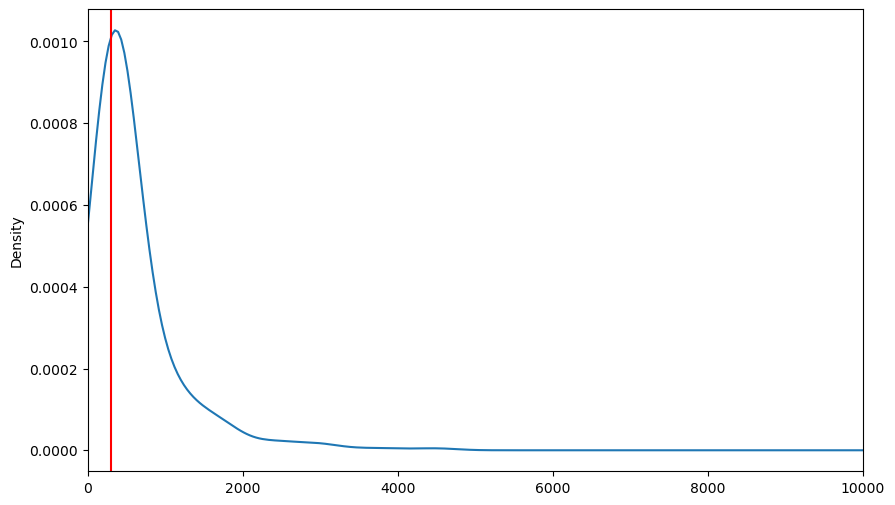

In [988]:
plt.figure(figsize=(10, 6))
pd.Series(imputed).plot(kind='density')
# set x lim
plt.xlim(0, 10000)
# add line at 300
plt.axvline(300, color='red')

In [ ]:
imputed_tax_series = pd.Series(imputed_tax)
imputed_tax_series

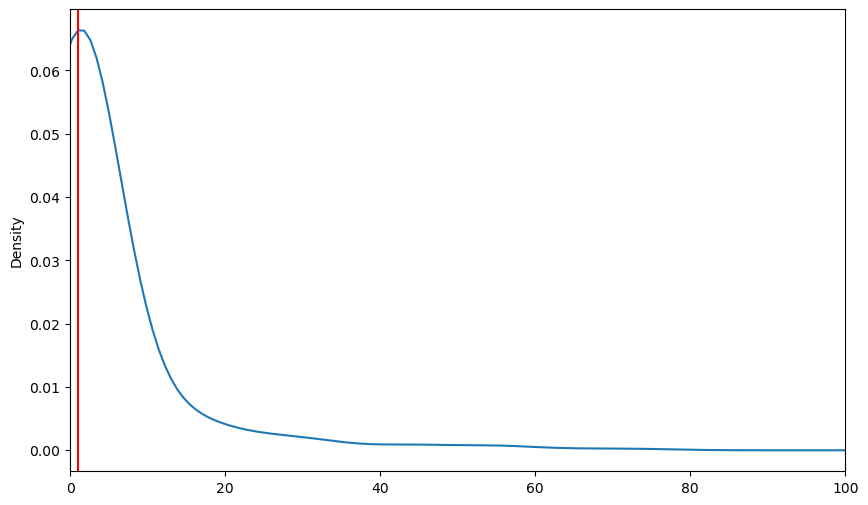

In [989]:
plt.figure(figsize=(10, 6))
pd.Series(imputed_tax).plot(kind='density')
# set x lim
plt.xlim(0, 100)
plt.axvline(1, color='red')

In [531]:
gini_coefficient(df["income_impute"])

0.5497132320771008

In [533]:
y_to_impute = df['income_impute'].values
imputed_tax = sample_from_lognormal(y_to_impute, n_missing)
gini_tax = gini_coefficient(imputed_tax)
print(gini_tax)

0.7196738424253606


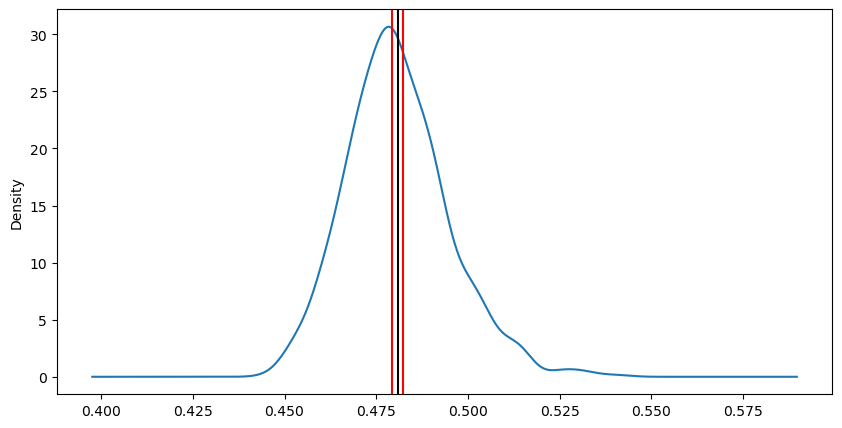

In [449]:
# plot ginis with confidence interval
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
ginis.plot(kind='density')
plt.axvline(ginis_stats['ci_lwr'], color='red')
plt.axvline(ginis_stats['ci_upr'], color='red')
plt.axvline(ginis_stats['mean'], color='black')
plt.show()

In [272]:
# ginis_random_simulated_incomes = ginis.copy()
# ginis_static_random_incomes = ginis.copy()

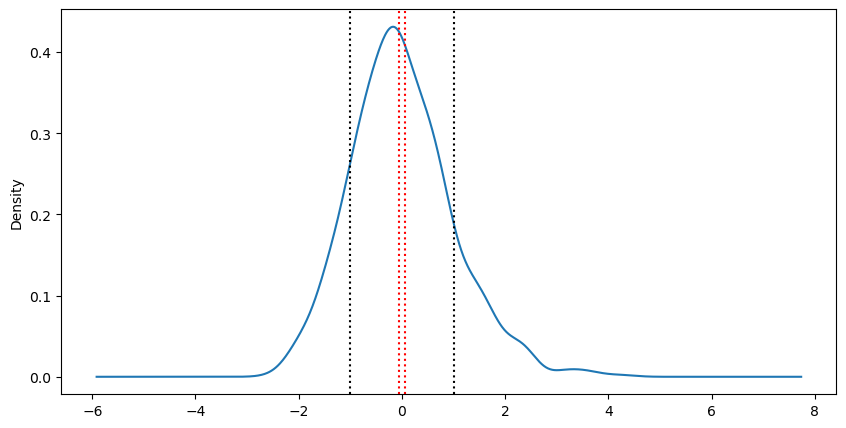

In [458]:
# plot gini's with lines for one and two standard deviations
import matplotlib.pyplot as plt
# standardize ginis
ginis_std = (ginis - ginis.mean()) / ginis.std()
# plot
plt.figure(figsize=(10, 5))
# plt.hist(ginis_std, bins=50)
ginis_std.plot(kind='density')
plt.axvline(x=1, color='black', linestyle='dotted')
plt.axvline(x=-1, color='black', linestyle='dotted')

lwr, upr = confidence(ginis_std, .95, 1000)
plt.axvline(x=lwr, color='red', linestyle='dotted')
plt.axvline(x=upr, color='red', linestyle='dotted')

plt.show()